In [18]:
import numpy as np
from scipy import *
from pylab import *
import healpy as hp
import os

######### notes for HOS hack on July 19 
######### Curved sky maps and catalogues generated by Joachim Harnois-Deraps
######### Notebook and flat sky by Jia Liu 

In [19]:
######## file paths
fn_curved = '/global/homes/j/jharno/IA-infusion/SkySim5000/kappa/1.0060kappa.npy'
# 0.06 gal/sq.arcmin
fn_cat006 = '/global/homes/j/jharno/IA-infusion/SkySim5000/GalCat/zs_plane/GalCat_zplane_zs1.006_0.06GpAM_RA_Dec_gamma1_gamma2_w_kappa.asc'
# 0.6 gal/sq.arcmin
fn_cat06 = '/global/homes/j/jharno/IA-infusion/SkySim5000/GalCat/zs_plane/GalCat_zplane_zs1.006_0.6GpAM_RA_Dec_gamma1_gamma2_w_kappa.asc'
# 12 gal/sq.arcmin
fn_cat12 = '/global/homes/j/jharno/IA-infusion/SkySim5000/GalCat/zs_plane/GalCat_zplane_zs1.006_1.2GpAM_RA_Dec_gamma1_gamma2_w_kappa.asc'

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


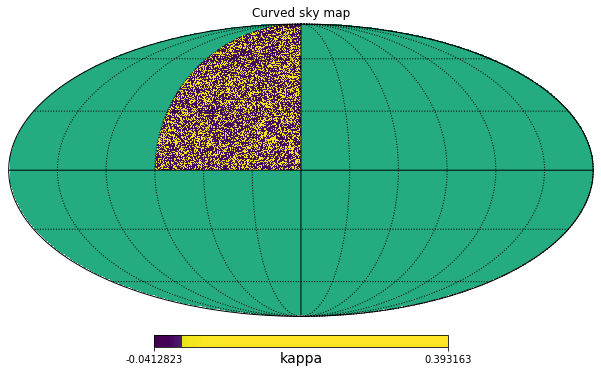

In [36]:
hpmap = np.load(fn_curved)
hp.mollview(
   hpmap,
    title="Curved sky map",
    unit="kappa",
    norm="hist",
    nest=False ## True would be Ring
)

hp.graticule(local=1)

In [28]:
from healpy import pixelfunc
nside=pixelfunc.get_nside(hpmap)
print ('Nside=',nside)

Nside= 8192


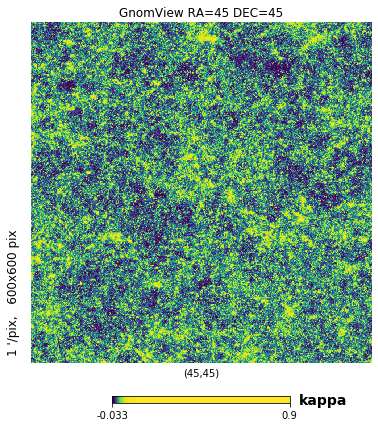

In [42]:
i,j=45, 45
mapsize=5 # map size in degrees
res_arcmin=0.5
Npix=mapsize*60/res_arcmin
out=hp.gnomview(hpmap, rot=[45,45], unit="kappa", format="%.2g",
                        title="GnomView RA=%s DEC=%s" %(i, j), 
                xsize = Npix, ## number of pixels 
                reso = 1, ## resolution in arcmin
                norm="hist",
                return_projected_map=True)

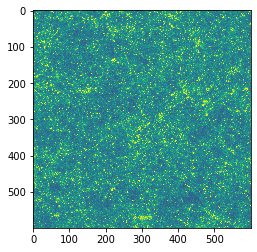

In [46]:
istd=std(out)
imshow(out, vmin=-3*istd, vmax=3*istd)
show()

In [47]:
########## load curved sky catalogues

cat_006=np.loadtxt(fn_cat006)
cat_06=np.loadtxt(fn_cat06)
cat_12=np.loadtxt(fn_cat12)

In [52]:
cat_006.shape ####### what are the columns? 

(1113829, 6)